# VAE

In this section you are required to implement Variational Autoencoder. The general structure for VAE is given below. You can use it as a template.

Variational Autoencoder is a type of autoencoder that can be used as a generative model. It has a reparametrization trick in bottleneck part.

There are couple of studies you can examine before implementing the model.

Auto-Encoding Variational Bayes: 
https://arxiv.org/abs/1312.6114

Understanding Variational Autoencoders (VAEs): https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73



**Link of the latest trained model= https://drive.google.com/open?id=1gaDp0qYBfa-A2g6jPB0jrqDkGHTKGxhY **

# Environment setup
Follow the tutorial about how to utilize Google Colab but **don't install PyTorch** as mentioned in the blog post.

Turkish:
https://medium.com/deep-learning-turkiye/google-colab-ile-%C3%BCcretsiz-gpu-kullan%C4%B1m%C4%B1-30fdb7dd822e

English:
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d



In [1]:
#from google.colab import drive
#drive.mount('/content/drive/', force_remount=True)

In [2]:
!nvidia-smi
# This command should return some information about the GPU status if the runtime is right. 
# In addition to that, if you encounter memory issues, you can diagnose your model by this command.

Wed Dec 11 20:52:19 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:01:00.0  On |                  N/A |
| 25%   59C    P8    17W / 250W |     96MiB / 12209MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load the MNIST data

In [4]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

# Implement the VAE Architecture of your Design

Use Conv2d, ConvTranspose2d and Activation Layers to design a Variational Autoencoder Architecture

In [5]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class VAE(torch.nn.Module):
    """
    Implement Variational Autoencoder
    """
    def __init__(self):
        """
        Implement architecture
        """
        super(VAE, self).__init__()
        self.c = 128
        self.latent_space = 4
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=self.c, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=self.c, out_channels=self.c*2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            Flatten()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.c*2, out_channels=self.c, kernel_size=4, stride=2, padding=1), 
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=self.c, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
        self.latent_sampler = nn.Linear(in_features=self.latent_space, out_features=self.c*2*7*7)
        self.means  = nn.Linear(in_features=self.c*2*7*7, out_features=self.latent_space)
        self.sigmas = nn.Linear(in_features=self.c*2*7*7, out_features=self.latent_space)


    
    def encode(self,x):
        self.batch_size = x.size()[0]
        x = self.encoder(x) 
        means = self.means(x)
        sigmas = self.sigmas(x)
        std = sigmas.mul(0.5).exp_()
        eps = torch.empty_like(std).normal_()
        
        latent_sampled = eps.mul(std).add_(means)  
        return latent_sampled, means, sigmas
    
    def decode(self,x):
        
        x = self.latent_sampler(x)
        x = x.view(self.batch_size, self.c*2, 7, 7)
        x_reconstructed = self.decoder(x)        
        return x_reconstructed
        
    def forward(self, x):
        """
        Implement forward-pass
        """
        latent_space, means, sigmas = self.encode(x)
        x_reconstructed = self.decode(latent_space)
        return x_reconstructed, means, sigmas 
    

In [6]:
use_gpu = True
vae = VAE()
if use_gpu:
    vae = vae.cuda()

# Initialization of the Optimizer: You can change the Parameters according to your needs

In [7]:
optimizer = optim.Adam(vae.parameters(), lr=3e-4)

# Variational Autoencoder combines Reconstruction Loss and KL Divergence Loss

In [8]:
# I use both BCE and KL divergence loss for the VAE
import torch.nn.functional as F
def calculate_loss(real_image,output, mean, sigma):
    # BCE Loss
    #BCE_loss = F.mse_loss(output, real_image, reduction='sum')
    BCE_loss = F.binary_cross_entropy(output.view(-1, 784), real_image.view(-1, 784), reduction='sum')
    # KL Divergence loss
    KL_loss = -0.5 * torch.sum(1 + sigma.data - mean.data.pow(2) - sigma.data.exp())
    
    # Combine both losses
    return (BCE_loss + KL_loss)

# Implement training loop

In [9]:
num_epochs = 150
losses_iter_train = []
losses_epoch_train = []

for epoch in range(num_epochs):
    count = 0
    for n_batch, (batch,_) in enumerate(train_loader):
        optimizer.zero_grad()
        if use_gpu:
            batch = batch.cuda()
        
        output, mu, sigma = vae(batch)
        # Calculate loss 
        loss = calculate_loss(batch,output, mu, sigma)
        losses_iter_train.append(loss.item())
        
        
        # Back propagate the model
        loss.backward()
        optimizer.step()
        count += 1

        if (n_batch + 1) % 100 == 0:
            print("epoch: {%d}, batch number: {%d}, error: {%.4f}" % 
                  (epoch + 1, n_batch + 1, loss.item(), ))
   
    losses_epoch_train.append(np.mean(losses_iter_train[-count:]))

epoch: {1}, batch number: {100}, error: {27525.2051}
epoch: {1}, batch number: {200}, error: {26608.6562}
epoch: {1}, batch number: {300}, error: {25931.2090}
epoch: {1}, batch number: {400}, error: {26219.3867}
epoch: {2}, batch number: {100}, error: {25312.5000}
epoch: {2}, batch number: {200}, error: {25055.6973}
epoch: {2}, batch number: {300}, error: {23500.1348}
epoch: {2}, batch number: {400}, error: {24337.1914}
epoch: {3}, batch number: {100}, error: {23801.8828}
epoch: {3}, batch number: {200}, error: {21932.6914}
epoch: {3}, batch number: {300}, error: {23238.9141}
epoch: {3}, batch number: {400}, error: {21859.7793}
epoch: {4}, batch number: {100}, error: {22637.1094}
epoch: {4}, batch number: {200}, error: {22341.8438}
epoch: {4}, batch number: {300}, error: {21557.5742}
epoch: {4}, batch number: {400}, error: {21624.0469}
epoch: {5}, batch number: {100}, error: {21296.5488}
epoch: {5}, batch number: {200}, error: {21823.4805}
epoch: {5}, batch number: {300}, error: {20730

epoch: {39}, batch number: {200}, error: {19056.4844}
epoch: {39}, batch number: {300}, error: {18632.3594}
epoch: {39}, batch number: {400}, error: {18543.5156}
epoch: {40}, batch number: {100}, error: {18480.8750}
epoch: {40}, batch number: {200}, error: {18631.9102}
epoch: {40}, batch number: {300}, error: {18742.0977}
epoch: {40}, batch number: {400}, error: {19227.8926}
epoch: {41}, batch number: {100}, error: {19479.0508}
epoch: {41}, batch number: {200}, error: {18475.2324}
epoch: {41}, batch number: {300}, error: {18107.0898}
epoch: {41}, batch number: {400}, error: {18689.5352}
epoch: {42}, batch number: {100}, error: {18582.4277}
epoch: {42}, batch number: {200}, error: {18260.0234}
epoch: {42}, batch number: {300}, error: {19017.5410}
epoch: {42}, batch number: {400}, error: {19119.1230}
epoch: {43}, batch number: {100}, error: {18781.5781}
epoch: {43}, batch number: {200}, error: {18545.0742}
epoch: {43}, batch number: {300}, error: {19347.7656}
epoch: {43}, batch number: {

epoch: {77}, batch number: {200}, error: {18936.6816}
epoch: {77}, batch number: {300}, error: {19179.4609}
epoch: {77}, batch number: {400}, error: {19744.1758}
epoch: {78}, batch number: {100}, error: {18321.4180}
epoch: {78}, batch number: {200}, error: {19003.5117}
epoch: {78}, batch number: {300}, error: {18521.0820}
epoch: {78}, batch number: {400}, error: {18974.7031}
epoch: {79}, batch number: {100}, error: {19186.3125}
epoch: {79}, batch number: {200}, error: {18858.5430}
epoch: {79}, batch number: {300}, error: {18886.6758}
epoch: {79}, batch number: {400}, error: {18482.6191}
epoch: {80}, batch number: {100}, error: {18767.9688}
epoch: {80}, batch number: {200}, error: {19077.3848}
epoch: {80}, batch number: {300}, error: {19117.6641}
epoch: {80}, batch number: {400}, error: {18678.4883}
epoch: {81}, batch number: {100}, error: {19498.9453}
epoch: {81}, batch number: {200}, error: {18974.2930}
epoch: {81}, batch number: {300}, error: {19211.5742}
epoch: {81}, batch number: {

epoch: {115}, batch number: {100}, error: {19356.7852}
epoch: {115}, batch number: {200}, error: {19185.3281}
epoch: {115}, batch number: {300}, error: {19025.1191}
epoch: {115}, batch number: {400}, error: {19253.9375}
epoch: {116}, batch number: {100}, error: {18582.0586}
epoch: {116}, batch number: {200}, error: {19376.7852}
epoch: {116}, batch number: {300}, error: {19042.5469}
epoch: {116}, batch number: {400}, error: {18898.7695}
epoch: {117}, batch number: {100}, error: {18913.8242}
epoch: {117}, batch number: {200}, error: {18551.8906}
epoch: {117}, batch number: {300}, error: {18562.2598}
epoch: {117}, batch number: {400}, error: {18893.8125}
epoch: {118}, batch number: {100}, error: {18296.6387}
epoch: {118}, batch number: {200}, error: {18925.3906}
epoch: {118}, batch number: {300}, error: {19114.4590}
epoch: {118}, batch number: {400}, error: {19237.8613}
epoch: {119}, batch number: {100}, error: {19280.1250}
epoch: {119}, batch number: {200}, error: {18508.6875}
epoch: {11

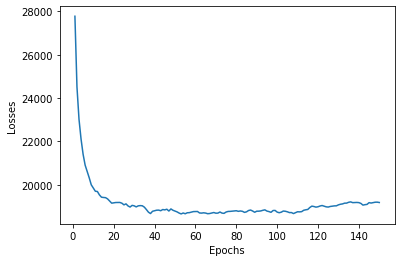

In [13]:
# Plot VAE Loss
plt.figure()
plt.plot([i+1 for i in range(len(losses_epoch_train))],losses_epoch_train)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.show()


## Randomly generate a sample then traverse in its latent space dimensions (add small numbers to only one dimension) see how it affects generated images

<Figure size 432x288 with 0 Axes>

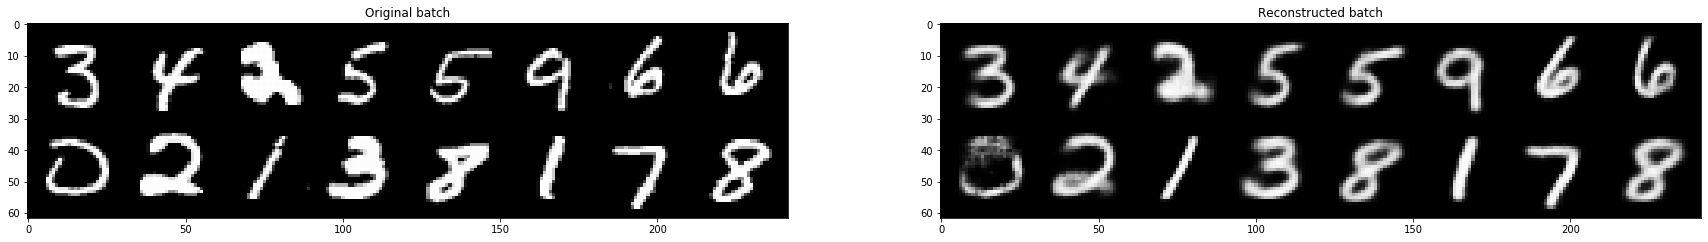

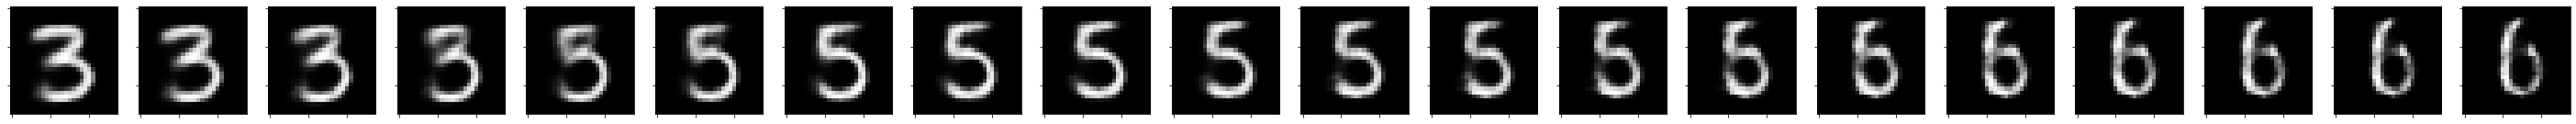

In [29]:
from IPython.display import Image
from IPython.core.display import Image, display
import torchvision
vae.eval()
# Get one batch 
test_iter = iter(train_loader)
random_batch,_ = next(test_iter)
if use_gpu:
    random_batch = random_batch.cuda()
#Create a latent space from any one batch
latent_space, _,_ = vae.encode(random_batch)

# Show the original and reconstruction of the batch
plt.figure()
batch_output = vae.decode(latent_space)
batch_output = batch_output.cpu().detach()
random_batch = random_batch.cpu().detach()
fig, axs = plt.subplots(1,2,figsize=(30,30))
batch_output_grid = torchvision.utils.make_grid(batch_output[:16]).numpy()
random_batch_grid = torchvision.utils.make_grid(random_batch[:16]).numpy()
axs[0].imshow(np.transpose(random_batch_grid, (1, 2, 0)))
axs[0].title.set_text('Original batch')
axs[1].imshow(np.transpose(batch_output_grid, (1, 2, 0)))
axs[1].title.set_text('Reconstructed batch')
plt.show()

# For any example latent space within a batch 
# Increase a feature inside the latent space
# I increase the first dimension of the latent space
# Also note that my latent space is 4 dimensional
# So for each image we have 4 different dimension to increase
latent_space = latent_space.cpu().detach()
latent_walk = np.arange(latent_space[0,0],latent_space[0,0]+3,0.15)


fig, axs = plt.subplots(1,len(latent_walk),figsize=(50,50))

latent_vector = latent_space
for i,data in enumerate(latent_walk):
    latent_vector[0,0] = data
    latent_vector = latent_vector.cuda()
    reconstruction = vae.decode(latent_vector)
    axs[i].imshow(reconstruction[0][0].data.cpu(),cmap="binary_r")
    axs[i].set_xticklabels("")
    axs[i].set_yticklabels("")
plt.show()

#### After you have completed the training, save your model using the following command
**Link of the latest trained model= https://drive.google.com/open?id=1gaDp0qYBfa-A2g6jPB0jrqDkGHTKGxhY **

In [30]:
student_id = 504191504
torch.save(vae.state_dict(),'drive/My Drive/blg561/{}_VAE.pth'.format(student_id))